Author: Zidong Chen

Date: 2024/07/19

In [1]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import core.GP_CommonCalculation as GP
from core.kernel import RBFKernel, LinearKernel, ARDKernel,RationalQuadraticKernel, PeriodicKernel
import numpy as np
from core.cigp_baseline import cigp
# I use torch (1.11.0) for this work. lower version may not work.
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

In [2]:
class NeuralKernel(nn.Module):
    def __init__(self, input_dim):
        super(NeuralKernel, self).__init__()

        # 定义核函数
        self.kernels = nn.ModuleDict({
            'RationalQuadratic': RationalQuadraticKernel(input_dim),
            'linear': LinearKernel(input_dim),
            'periodic': PeriodicKernel(initial_period=1.0),
            'RBF': RBFKernel(input_dim)
        })
        self.softplus = nn.Softplus()
        # 定义核函数的可学习权重
        self.weights = nn.ParameterDict({
            'RationalQuadratic': nn.Parameter(torch.tensor(2.0)),
            'linear': nn.Parameter(torch.tensor(1.0)),
            'periodic': nn.Parameter(torch.tensor(1.0)),
            'RBF': nn.Parameter(torch.tensor(1.0))
        })

    def forward(self, x1, x2):
        # 计算每个核函数的输出并加权相加
        K_sum = sum(self.softplus(self.weights[name]) * kernel(x1, x2)
                    for name, kernel in self.kernels.items())
        return K_sum

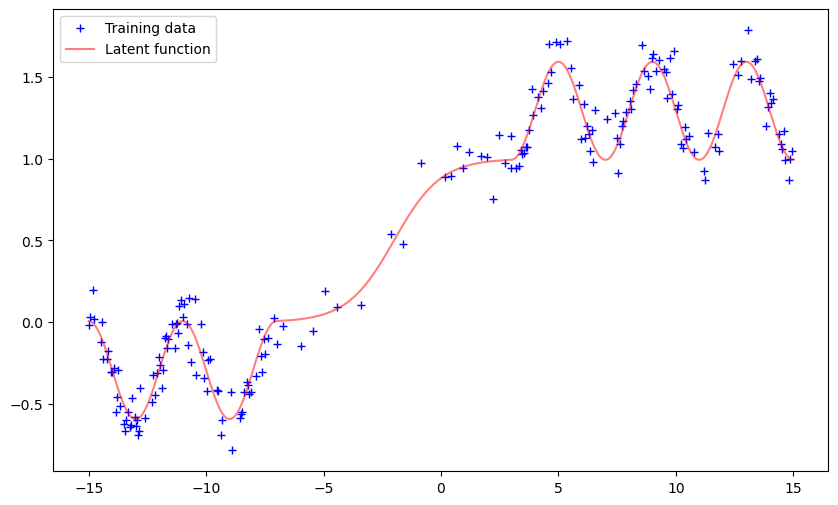

In [3]:
# generate example data
xtr, ytr, xte, yte, x_combined, y_combined = data.generate_complex_data(400, seed=1)

data.plot(xtr, ytr, x_combined, y_combined)

In [4]:
x_dim = xtr.size(1)

NKGP = cigp(xtr, ytr, NeuralKernel)
NKGP.train_adam(200, 0.1)

iter 0 nll:587.46568
iter 10 nll:487.58768
iter 20 nll:389.48831
iter 30 nll:293.29040
iter 40 nll:201.79574
iter 50 nll:121.47093
iter 60 nll:64.90590
iter 70 nll:45.90248
iter 80 nll:47.94112
iter 90 nll:13.44814
iter 100 nll:-28.13930
iter 110 nll:-70.94493
iter 120 nll:-79.16817
iter 130 nll:-82.69014
iter 140 nll:-82.74668
iter 150 nll:-83.21938
iter 160 nll:-83.59717
iter 170 nll:-84.17507
iter 180 nll:-84.52769
iter 190 nll:-84.71863


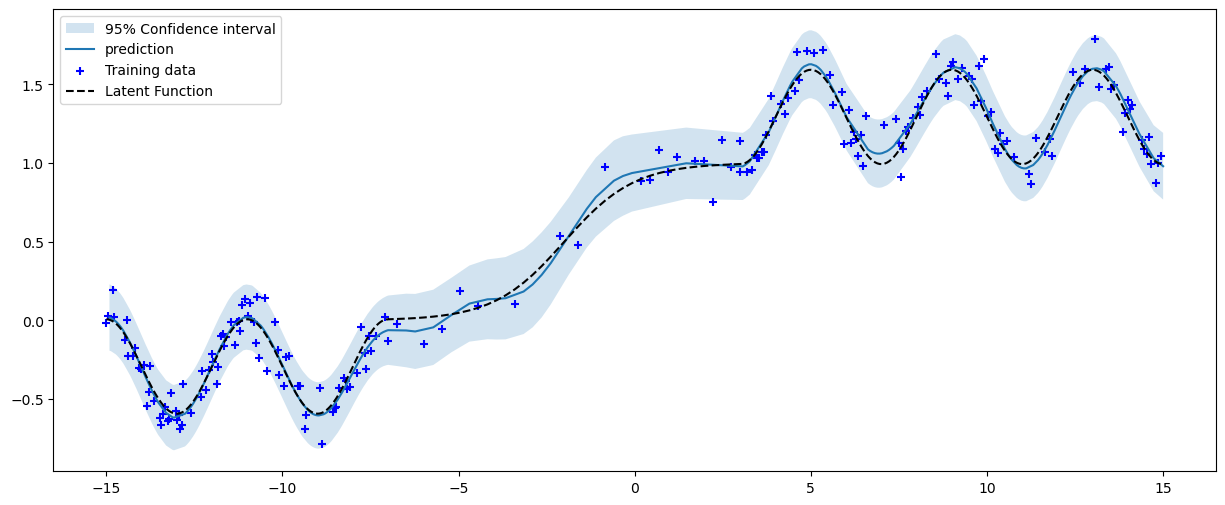

Weight for RBF kernel: 0.002457887700393516
Weight for RationalQuadratic kernel: 0.6545490508451304
Weight for linear kernel: 1.0962962398626357
Weight for periodic kernel: 0.1822676774971167


In [5]:
# Generate predictions
with torch.no_grad():
    ypred, yvar = NKGP.forward(xte)

# Sort xte and get the sorted indices
sorted_indices = torch.argsort(xte.squeeze())

# Apply the sorted indices to xte, ypred, and yvar
xte_sorted = xte[sorted_indices]
ypred_sorted = ypred[sorted_indices]
yvar_sorted = yvar[sorted_indices]

plt.figure(figsize=(15, 6))
# Plotting the predictions with error bars
plt.fill_between(
    xte_sorted.squeeze().numpy(),
    ypred_sorted.squeeze().detach().numpy() - 1.96 * np.sqrt(yvar_sorted.squeeze().detach().numpy()),
    ypred_sorted.squeeze().detach().numpy() + 1.96 * np.sqrt(yvar_sorted.squeeze().detach().numpy()),
    alpha=0.2,
    label='95% Confidence interval'
)

# Plotting the predictions
plt.plot(xte_sorted.numpy(), ypred_sorted.numpy(), label='prediction')
plt.scatter(xtr, ytr, label='Training data', color='b', marker='+')
# Adding the latent function for reference
plt.plot(x_combined.numpy(), y_combined.numpy(), 'k--', label='Latent Function')

# Adding legend
plt.legend()
plt.show()

for name, param in NKGP.kernel.weights.items():
    print(f"Weight for {name} kernel: {NKGP.kernel.softplus(param).item()}")

iter 0 nll:585.79187
iter 10 nll:575.88509
iter 20 nll:565.98890
iter 30 nll:556.10534
iter 40 nll:546.23596
iter 50 nll:536.38156
iter 60 nll:526.54213
iter 70 nll:516.71676
iter 80 nll:506.90372
iter 90 nll:497.10085
iter 100 nll:487.30613
iter 110 nll:477.51842
iter 120 nll:467.73771
iter 130 nll:457.96494
iter 140 nll:448.20151
iter 150 nll:438.44892
iter 160 nll:428.70860
iter 170 nll:418.98195
iter 180 nll:409.27046
iter 190 nll:399.57574
iter 200 nll:389.89946
iter 210 nll:380.24353
iter 220 nll:370.60992
iter 230 nll:361.00082
iter 240 nll:351.41857
iter 250 nll:341.86573
iter 260 nll:332.34507
iter 270 nll:322.85963
iter 280 nll:313.41269
iter 290 nll:304.00785
iter 300 nll:294.64905
iter 310 nll:285.34056
iter 320 nll:276.08705
iter 330 nll:266.89362
iter 340 nll:257.76580
iter 350 nll:248.70961
iter 360 nll:239.73162
iter 370 nll:230.83888
iter 380 nll:222.03908
iter 390 nll:213.34047


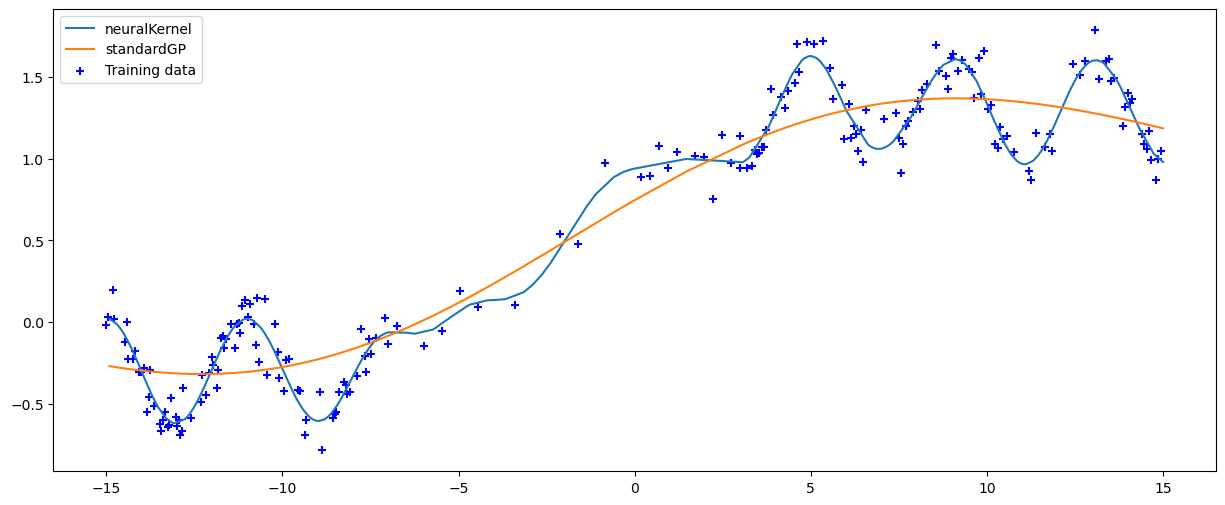

mse_neuralKernel: tensor(0.0012)
mse_standardGP: tensor(0.0477)


In [6]:
#Comparing with standard GP
standardGP = cigp(xtr, ytr, ARDKernel)
standardGP.train_adam(400, 0.01)
with torch.no_grad():
    ypred2, yvar2 = standardGP.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
ypred2_sorted = ypred2[sorted_indices]
plt.figure(figsize=(15, 6))
plt.plot(xte_sorted.numpy(), ypred_sorted.numpy(), label='neuralKernel')
plt.plot(xte_sorted.numpy(), ypred2_sorted.numpy(), label='standardGP')
plt.scatter(xtr, ytr, label='Training data', color='b', marker='+')
plt.legend()
plt.show()
print('mse_neuralKernel:', mse_neuralKernel)
print('mse_standardGP:', mse_standardGP)

### Conclusion
#### The neural kernel demonstrated here is a linear combination of multiple kernels, where the weights of each kernel are learned during training. This allows the neural kernel to model complex patterns in the data effectively. In this example, the neural kernel is compared with the standard Gaussian Process (GP) with an Automatic Relevance Determination (ARD) kernel. We observe that the neural kernel GP outperforms the standard GP in this scenario. This demonstrates that the neural kernel is a simple and effective method for automatically selecting the kernel function for a GP. You can change the data to a straight line or a simple periodic function to see how the neural kernel can automatically choose the appropriate linear or periodic kernel to model the data.